In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [3]:
df = pd.read_pickle(os.getcwd()+r"\Data Files\final_grids_combined.pkl")

In [ ]:
df[["SKP_CREDIT_CASE","NTC_FLAG"]].to_csv(os.getcwd()+r"\Data Files\ntc bifur.csv")

In [4]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df[["MONTH_STR","RISK_FSTQPD30"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

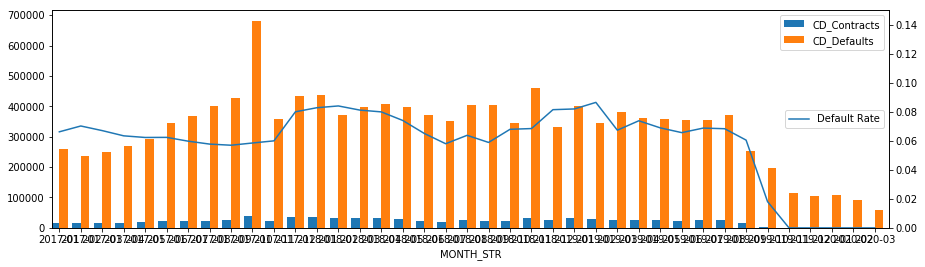

In [5]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


# Generate grid based scores for selected variables

In [6]:
selected_list =['RISK_FPD10_SCORE','RISK_FPD30_SCORE','RISK_FSTQPD30_SCORE','RISK_FPD10_MM_SCORE',
'DEFAULT_FLAG_CHANGE_1','NO_PAYMENT_CURRENT_PAYMENT_1','NO_PAYMENT_CURRENT_PAYMENT_2']

In [8]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters\Hyperparameters.csv")
df = pd.read_pickle(os.getcwd()+r"\Data Files\final_grids_combined.pkl")

In [9]:
df_month = pd.DataFrame({'month':[1,2,3,4,5,6,7,8,9,10,11,12,1],'year':[2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2020]})
#df_month = pd.DataFrame({'month':[11,12,1],'year':[2019,2019,2020]})

In [10]:
df_month

,month,year
0,1,2019
1,2,2019
2,3,2019
3,4,2019
4,5,2019
5,6,2019
6,7,2019
7,8,2019
8,9,2019
9,10,2019


In [11]:
df_final_test = pd.DataFrame()

In [12]:
import datetime
from sklearn.neighbors import KNeighborsClassifier

for t in df_month.index:
    x=df_month["month"][t]
    year=df_month["year"][t]
    date_test_start = datetime.datetime(year, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
        if hyper_df.loc[y,'SCORE_NAME'] in selected_list:
            score_name = hyper_df.loc[y,'SCORE_NAME']
            target = hyper_df.loc[y,'TARGET']
            K = hyper_df.loc[y,'K']
            observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
            performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
            downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']
            fillna = hyper_df.loc[y,'FILLNA']

            date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window))-datetime.timedelta(days=int(observation_window))) 
            date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)))
            start_time = datetime.datetime.now()
            df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
                      (df["TIME_DECISION_DATE"]<date_train_end)]

            df_class_0 = df_train[df_train[target] == 0]
            df_class_1 = df_train[df_train[target] == 1]
            df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
            df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
            df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

            X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
            X_test = df_test[["CUS_LAT","CUS_LONG"]]
            y_train = df_train_under[target]
            y_test =  df_test[target]

            knn = KNeighborsClassifier(n_neighbors = K)
            bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

            ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
            ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
            metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
#            metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
            gini_train = 2 * metric_auc_train - 1
#            gini_test = 2 * metric_auc_test - 1

            df_test[score_name] = ypred_test
            
            df_train_under ["G_"+score_name] = ypred_train
            grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
            grid_score.columns = ['GRID_ID',"G_"+score_name]
            
            df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
            df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)
            
            print("Training for predicting (month):",date_test_start.month, 
                  " SCORE:",score_name,
                  " target:",target,
                  " K:",K,
                  " observation_window:",observation_window,
                  " performance_window:",performance_window,
                  " downsample_size:",downsample_size,
                  " GINI TRAIN:",'{:,.2%}'.format(gini_train), 
#                   "    GINI TEST:",'{:,.2%}'.format(gini_test),
                  " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.02%  time taken:  0.87
Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.65%  time taken:  0.28
Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.45%  time taken:  2.0
Training for predicting (month): 1  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 18.30%  time taken:  0.48


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.24%  time taken:  0.78
Training for predicting (month): 2  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.79%  time taken:  0.25
Training for predicting (month): 2  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.13%  time taken:  1.9
Training for predicting (month): 2  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.06%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.26%  time taken:  0.85
Training for predicting (month): 3  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 21.69%  time taken:  0.27
Training for predicting (month): 3  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.48%  time taken:  1.9
Training for predicting (month): 3  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.58%  time taken:  0.45


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.31%  time taken:  0.8
Training for predicting (month): 4  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.08%  time taken:  0.27
Training for predicting (month): 4  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.06%  time taken:  1.9
Training for predicting (month): 4  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.94%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.56%  time taken:  0.8
Training for predicting (month): 5  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.49%  time taken:  0.25
Training for predicting (month): 5  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.12%  time taken:  1.9
Training for predicting (month): 5  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.67%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.30%  time taken:  0.8
Training for predicting (month): 6  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.38%  time taken:  0.25
Training for predicting (month): 6  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.13%  time taken:  1.9
Training for predicting (month): 6  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 17.37%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.06%  time taken:  0.8
Training for predicting (month): 7  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.26%  time taken:  0.25
Training for predicting (month): 7  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.42%  time taken:  1.9
Training for predicting (month): 7  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 18.22%  time taken:  0.43


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 17.45%  time taken:  0.82
Training for predicting (month): 8  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.83%  time taken:  0.27
Training for predicting (month): 8  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.53%  time taken:  1.9
Training for predicting (month): 8  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 17.55%  time taken:  0.45


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 9  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.86%  time taken:  0.67
Training for predicting (month): 9  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 23.20%  time taken:  0.22
Training for predicting (month): 9  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.74%  time taken:  1.8
Training for predicting (month): 9  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 16.27%  time taken:  0.35


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 10  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.65%  time taken:  0.8
Training for predicting (month): 10  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.22%  time taken:  0.25
Training for predicting (month): 10  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.64%  time taken:  2.1
Training for predicting (month): 10  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 15.29%  time taken:  0.28


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 11  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.59%  time taken:  0.5
Training for predicting (month): 11  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.07%  time taken:  0.12
Training for predicting (month): 11  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.66%  time taken:  1.5
Training for predicting (month): 11  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 14.53%  time taken:  0.18


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 12  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.53%  time taken:  0.48
Training for predicting (month): 12  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.11%  time taken:  0.12
Training for predicting (month): 12  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.36%  time taken:  1.5
Training for predicting (month): 12  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 13.35%  time taken:  0.17


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: RISK_FPD10_SCORE  target: RISK_FPD10  K: 271  observation_window: 365  performance_window: 40  downsample_size: 150000  GINI TRAIN: 16.42%  time taken:  0.52
Training for predicting (month): 1  SCORE: RISK_FPD30_SCORE  target: RISK_FPD30  K: 136  observation_window: 365  performance_window: 60  downsample_size: 50000  GINI TRAIN: 22.46%  time taken:  0.12
Training for predicting (month): 1  SCORE: RISK_FSTQPD30_SCORE  target: RISK_FSTQPD30  K: 376  observation_window: 365  performance_window: 150  downsample_size: 300000  GINI TRAIN: 15.26%  time taken:  1.4
Training for predicting (month): 1  SCORE: RISK_FPD10_MM_SCORE  target: RISK_FPD10  K: 241  observation_window: 110  performance_window: 40  downsample_size: 50000  GINI TRAIN: 14.42%  time taken:  0.13


In [13]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\scored_delinq_19_20_7pred.pkl")

In [14]:
df1 = pd.read_pickle(os.getcwd()+ r"\Data Files\recent_delinquency_small_combined.pkl")

In [15]:
df1.MONTH_PAY.value_counts()

2019-02-01    723886
2019-04-01    711038
2019-06-01    698123
2019-05-01    696816
2019-08-01    692535
2019-09-01    687987
2019-07-01    685901
2019-01-01    684146
2019-03-01    683003
2019-10-01    681127
2019-11-01    674997
2019-12-01    662698
2020-01-01    650247
2020-02-01    641222
Name: MONTH_PAY, dtype: int64

In [17]:
hyper_df= pd.read_csv(os.getcwd()+r"\Data Files\Hyperparameters\Hyperparameters_EMI_Payment_Trend.csv")

In [18]:
df_final_test = pd.DataFrame()

In [19]:


import datetime
from sklearn.neighbors import KNeighborsClassifier

for t in df_month.index:
    x=df_month["month"][t]
    year=df_month["year"][t]
    date_test_start = datetime.datetime(year, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                      (df["TIME_DECISION_DATE"]<date_test_end)]

    for y in hyper_df.index:
        if hyper_df.loc[y,'MONTH_HIST'] < x or year == 2020:
            if hyper_df.loc[y,'SCORE_NAME'] in selected_list:
                score_name = hyper_df.loc[y,'SCORE_NAME']
                target = hyper_df.loc[y,'TARGET']
                K = hyper_df.loc[y,'K']
                observation_window = hyper_df.loc[y,'OBSERVATION_WINDOW']
                performance_window = hyper_df.loc[y,'PERFORMANCE_WINDOW']
                downsample_size = hyper_df.loc[y,'DOWNSAMPLE_SIZE']

                date_train_start = (date_test_start-datetime.timedelta(days=int(performance_window)-1)-datetime.timedelta(days=int(observation_window))).replace(day=1) 
                date_train_end = (date_test_start-datetime.timedelta(days=int(performance_window)-2)).replace(day=1)
                start_time = datetime.datetime.now()
                df_train = df1[(df1["MONTH_PAY"]>=date_train_start) & 
                          (df1["MONTH_PAY"]<date_train_end)]

                df_class_0 = df_train[df_train[target] == 0]
                df_class_1 = df_train[df_train[target] == 1]
                df_class_0_under = df_class_0.sample(min(downsample_size,df_class_1.shape[0]))
                df_class_1_under = df_class_1.sample(min(downsample_size,df_class_1.shape[0]))
                df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

                X_train = df_train_under[["CUS_LAT","CUS_LONG"]]
                X_test = df_test[["CUS_LAT","CUS_LONG"]]
                y_train = df_train_under[target]
                y_test =  df_test['RISK_FSTQPD30']

                knn = KNeighborsClassifier(n_neighbors = K)
                bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

                ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
                ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]
                metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
#                 metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
                gini_train = 2 * metric_auc_train - 1
#                 gini_test = 2 * metric_auc_test - 1

                df_test[score_name] = ypred_test
                df_train_under ["G_"+score_name] = ypred_train
                grid_score = df_train_under[["GRID_ID","G_"+score_name]].groupby("GRID_ID").mean()["G_"+score_name].reset_index()
                grid_score.columns = ['GRID_ID',"G_"+score_name]

                df_test = pd.merge(df_test, grid_score, on = 'GRID_ID', how = 'left')
                df_test["G_"+score_name]=df_test["G_"+score_name].fillna(value = fillna)

                print("Training for predicting (month):",date_test_start.month, 
                      " SCORE:",score_name,
                      " target:",target,
                      " K:",K,
                      " observation_window:",observation_window,
                      " performance_window:",performance_window,
                      " downsample_size:",downsample_size,
                      " GINI TRAIN:",'{:,.2%}'.format(gini_train),
#                       "    GINI TEST:",'{:,.2%}'.format(gini_test),
                      " time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))
        else:
            print("History not available")


    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)


History not available
History not available
History not available
History not available
History not available
History not available
History not available
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.74%  time taken:  0.27
History not available
History not available
History not available
History not available
Training for predicting (month): 2  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 15.69%  time taken:  1.8
History not available
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.24%  time taken:  0.3
History not available
History not available
History not available
Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.08%  time taken:  1.8
Training for predicting (month): 3  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 15.62%  time taken:  1.8
History not available
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 20.15%  time taken:  0.28
History not available
History not available
Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.04%  time taken:  1.8
Training for predicting (month): 4  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.40%  time taken:  1.9
History not available
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 19.72%  time taken:  0.3
History not available
Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.10%  time taken:  1.9
Training for predicting (month): 5  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.10%  time taken:  1.8
History not available


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 6  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.04%  time taken:  0.3
Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.15%  time taken:  1.9
Training for predicting (month): 6  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.09%  time taken:  1.9


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 7  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.06%  time taken:  0.3
Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.75%  time taken:  1.9
Training for predicting (month): 7  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.23%  time taken:  1.9


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 8  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 21.51%  time taken:  0.3
Training for predicting (month): 8  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.41%  time taken:  1.9
Training for predicting (month): 8  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.86%  time taken:  1.9


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 9  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.55%  time taken:  0.27
Training for predicting (month): 9  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.29%  time taken:  1.7
Training for predicting (month): 9  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.44%  time taken:  1.7


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 10  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.25%  time taken:  0.22
Training for predicting (month): 10  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.18%  time taken:  1.5
Training for predicting (month): 10  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.30%  time taken:  1.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 11  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 23.12%  time taken:  0.15
Training for predicting (month): 11  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.25%  time taken:  1.4
Training for predicting (month): 11  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.17%  time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 12  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 21.33%  time taken:  0.13
Training for predicting (month): 12  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.03%  time taken:  1.4
Training for predicting (month): 12  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.28%  time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1  SCORE: DEFAULT_FLAG_CHANGE_1  target: DEFAULT_FLAG_CHANGE  K: 136  observation_window: 30  performance_window: 0  downsample_size: 80000  GINI TRAIN: 22.39%  time taken:  0.13
Training for predicting (month): 1  SCORE: NO_PAYMENT_CURRENT_PAYMENT_1  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 0  downsample_size: 300000  GINI TRAIN: 16.13%  time taken:  1.4
Training for predicting (month): 1  SCORE: NO_PAYMENT_CURRENT_PAYMENT_2  target: NO_PAYMENT_CURRENT_PAYMENT  K: 351  observation_window: 30  performance_window: 30  downsample_size: 300000  GINI TRAIN: 16.10%  time taken:  1.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [20]:
df_final_test.to_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_19_20_7pred.pkl")

In [21]:
df=pd.read_pickle(os.getcwd()+r"\Data Files\scored_delinq_19_20_7pred.pkl")

In [22]:
df1= pd.read_pickle(os.getcwd()+r"\Data Files\emi_payment_scores_19_20_7pred.pkl")

In [23]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FPD10', 'RISK_FPD30', 'RISK_FSPD30', 'RISK_FSTPD30',
       'RISK_FSTQPD30', 'RISK_FSTQPD60', 'NTC_FLAG', 'GRID_ID', 'RISK_SCORE',
       'RISK_FPD10_SCORE', 'G_RISK_FPD10_SCORE', 'RISK_FPD30_SCORE',
       'G_RISK_FPD30_SCORE', 'RISK_FSTQPD30_SCORE', 'G_RISK_FSTQPD30_SCORE',
       'RISK_FPD10_MM_SCORE', 'G_RISK_FPD10_MM_SCORE'],
      dtype='object')

In [24]:
df1

,CUS_LAT,CUS_LONG,DEFAULT_FLAG_CHANGE_1,GRID_ID,G_DEFAULT_FLAG_CHANGE_1,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2,NO_PAYMENT_CURRENT_PAYMENT_1,NO_PAYMENT_CURRENT_PAYMENT_2,NTC_FLAG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,RISK_SCORE,SKP_CREDIT_CASE,TIME_DECISION_DATE
0,26.196128,73.002229,NaN,500_01007_04165,NaN,NaN,NaN,NaN,NaN,Others,0.0,0.0,0.0,0.0,0.0,0.0,0.037345,220543872,2019-01-01
1,26.280459,72.987023,NaN,500_01005_04183,NaN,NaN,NaN,NaN,NaN,Others,0.0,0.0,0.0,0.0,0.0,0.0,0.016066,220543873,2019-01-01
2,21.116755,79.104340,NaN,500_02197_03028,NaN,NaN,NaN,NaN,NaN,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.054663,220543874,2019-01-01
3,18.637497,73.836025,NaN,500_01099_02515,NaN,NaN,NaN,NaN,NaN,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.111290,219906800,2019-01-01
4,23.194511,77.462190,NaN,500_01870_03483,NaN,NaN,NaN,NaN,NaN,Others,0.0,0.0,0.0,0.0,0.0,0.0,NaN,219993472,2019-01-01
5,19.155484,72.845582,NaN,500_00899_02638,NaN,NaN,NaN,NaN,NaN,Others,0.0,0.0,0.0,0.0,0.0,0.0,0.007069,220005765,2019-01-01
6,28.504690,77.231656,NaN,500_01846_04638,NaN,NaN,NaN,NaN,NaN,NTC,1.0,0.0,0.0,0.0,1.0,1.0,0.094786,220099958,2019-01-01
7,26.245851,78.180434,NaN,500_02023_04144,NaN,NaN,NaN,NaN,NaN,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.168091,220365451,2019-01-01
8,30.906733,75.941345,NaN,500_01613_05169,NaN,NaN,NaN,NaN,NaN,Others,0.0,0.0,0.0,0.0,0.0,0.0,0.022668,220366805,2019-01-01
9,28.587934,77.386740,NaN,500_01877_04656,NaN,NaN,NaN,NaN,NaN,NTC,0.0,0.0,0.0,0.0,0.0,0.0,0.209447,220369231,2019-01-01


In [25]:
df1 = df1[['DEFAULT_FLAG_CHANGE_1', 'SKP_CREDIT_CASE', 'G_DEFAULT_FLAG_CHANGE_1',
          'G_NO_PAYMENT_CURRENT_PAYMENT_1','G_NO_PAYMENT_CURRENT_PAYMENT_2','NO_PAYMENT_CURRENT_PAYMENT_1','NO_PAYMENT_CURRENT_PAYMENT_2'
          ]]

In [26]:
df= df.merge(df1, on = 'SKP_CREDIT_CASE',how = 'right')

In [27]:
df.shape

(3701342, 27)

In [28]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,...,RISK_FSTQPD30_SCORE,G_RISK_FSTQPD30_SCORE,RISK_FPD10_MM_SCORE,G_RISK_FPD10_MM_SCORE,DEFAULT_FLAG_CHANGE_1,G_DEFAULT_FLAG_CHANGE_1,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2,NO_PAYMENT_CURRENT_PAYMENT_1,NO_PAYMENT_CURRENT_PAYMENT_2
0,220543872,2019-01-01,26.196128,73.002229,0.0,0.0,0.0,0.0,0.0,0.0,...,0.446809,0.440851,0.443983,0.446058,NaN,NaN,NaN,NaN,NaN,NaN
1,220543873,2019-01-01,26.280459,72.987023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.468085,0.468514,0.481328,0.483748,NaN,NaN,NaN,NaN,NaN,NaN
2,220543874,2019-01-01,21.116755,79.104340,0.0,0.0,0.0,0.0,0.0,0.0,...,0.484043,0.487062,0.452282,0.441909,NaN,NaN,NaN,NaN,NaN,NaN
3,219906800,2019-01-01,18.637497,73.836025,0.0,0.0,0.0,0.0,0.0,0.0,...,0.412234,0.413155,0.356846,0.356846,NaN,NaN,NaN,NaN,NaN,NaN
4,219993472,2019-01-01,23.194511,77.462190,0.0,0.0,0.0,0.0,0.0,0.0,...,0.433511,0.441622,0.402490,0.398933,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
scores_columns= ['RISK_SCORE',
 'G_RISK_FPD10_SCORE','G_RISK_FPD30_SCORE','G_RISK_FSTQPD30_SCORE','G_RISK_FPD10_MM_SCORE','G_DEFAULT_FLAG_CHANGE_1',
                 'G_NO_PAYMENT_CURRENT_PAYMENT_1','G_NO_PAYMENT_CURRENT_PAYMENT_2'
                ]

# Convert All Scores to Logit

In [37]:
df.dropna(subset = ['RISK_SCORE'], inplace = True)
for y in scores_columns:
    df["LOGIT_"+y] = [np.log(x/(1-x)) for x in df[y]]

In [38]:
logit_columns= [x for x in df.columns if 'LOGIT' in x]

In [39]:
df1=df[df.TIME_DECISION_DATE>=datetime.datetime(2019,3,1)]

In [41]:
df1["COMBINED_SCORE_KNN"] = np.where(df1["NTC_FLAG"]!='NTC',1/(1+np.exp(-(df1["LOGIT_G_RISK_FPD30_SCORE"]*0.133694+ 
              df1["LOGIT_G_RISK_FSTQPD30_SCORE"]*0.253384 +
              df1["LOGIT_G_DEFAULT_FLAG_CHANGE_1"]*0.138207 +
              df1["LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_2"]*0.298317 +
              df1["LOGIT_G_RISK_FPD10_MM_SCORE"]*0.189856 +
              df1["LOGIT_G_RISK_FPD10_SCORE"]*0.163698 +  -2.7974444))),1/(1+np.exp(-(df1["LOGIT_G_RISK_FSTQPD30_SCORE"]*0.495134+ 
              df1["LOGIT_G_NO_PAYMENT_CURRENT_PAYMENT_1"]*0.246826 +
                df1["LOGIT_G_DEFAULT_FLAG_CHANGE_1"]*0.128352 +
              df1["LOGIT_G_RISK_FPD10_MM_SCORE"]*0.123364 +  -2.37891549))))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [43]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE_KNN"]) - 1))

GINI COMBINED:  19.69%


In [45]:
df1["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df1["RISK_SCORE"]]
df1["LOGIT_COMBINED_SCORE_KNN"] = [np.log(x/(1-x)) for x in df1["COMBINED_SCORE_KNN"]]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
df1["COMBINED_SCORE"] = np.where(df1["NTC_FLAG"]!= 'NTC', 1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.943849+ 
              df1["LOGIT_COMBINED_SCORE_KNN"]*0.791181 + 2.69028934))),1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.617087+ 
              df1["LOGIT_COMBINED_SCORE_KNN"]*0.828352 + 0.69204446))))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
df1["RISK_SCORE_SCALED"]=np.where(df1["NTC_FLAG"]!= 'NTC',1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.951458+ 
              0.45331401))),1/(1+np.exp(-(df1["LOGIT_RISK_SCORE"]*0.655804+ 
              -1.23188016))))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["COMBINED_SCORE"]) - 1))
print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df1["RISK_FSTQPD30"], df1["RISK_SCORE_SCALED"]) - 1))

GINI COMBINED:  36.15%
GINI COMBINED:  35.29%


In [53]:
df1.to_pickle(os.getcwd()+"\Data Files\Combined_score_19_20_7pred.pkl")

In [54]:
df = df1

In [55]:
TIME_DECISION_DATE = "TIME_DECISION_DATE"
FINAL_SCORE = "COMBINED_SCORE_KNN"
RISK_SCORE = "RISK_SCORE_SCALED"
COMBINED_SCORE = "COMBINED_SCORE"
PREDICTOR_LIST = ['G_RISK_FPD10_SCORE','G_RISK_FPD30_SCORE','G_RISK_FSTQPD30_SCORE','G_RISK_FPD10_MM_SCORE','G_DEFAULT_FLAG_CHANGE_1',
                 'G_NO_PAYMENT_CURRENT_PAYMENT_1','G_NO_PAYMENT_CURRENT_PAYMENT_2']
df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [56]:
TARGET = {
          "RISK_FSTQPD30":150,
          "RISK_FSTPD30":120,
          "RISK_FSPD30":90,
          "RISK_FPD30":60
         }


In [57]:
df["MONTH"].unique()

array(['19-03', '19-04', '19-05', '19-06', '19-07', '19-08', '19-09',
       '19-10', '19-11', '19-12', '20-01'], dtype=object)

In [58]:
x = '19-09'
df[(df["MONTH"]==x)&(df["TIME_DECISION_DATE"]<= datetime.datetime(2020,3,15)-datetime.timedelta(150))].shape[0]

242928

In [59]:
df1=df

In [60]:
df1.NTC_FLAG.value_counts()

Others    1619753
NTC       1034848
Name: NTC_FLAG, dtype: int64

In [67]:
df = df1

In [68]:
from sklearn.metrics import roc_auc_score
gini_dic = {}
for x in df["MONTH"].unique():
    for y in TARGET:        
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "TARGET" not in gini_dic:
            gini_dic["TARGET"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        gini_dic["MONTH"].append(x)
        gini_dic["TARGET"].append(y)
        if df[(df["MONTH"]==x)&(df["TIME_DECISION_DATE"]<= datetime.datetime(2020,3,15)-datetime.timedelta(TARGET[y]))].shape[0]>0:
            gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
            gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
            gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
            for z in PREDICTOR_LIST:
                if z not in gini_dic:
                      gini_dic[z] = []
                gini_dic[z].append(((2*roc_auc_score(df[df["MONTH"]==x][y],df[df["MONTH"]==x][z])-1)*100))
        else:
            gini_dic[FINAL_SCORE].append(np.nan)
            gini_dic[RISK_SCORE].append(np.nan)
            gini_dic[COMBINED_SCORE].append(np.nan)
            for z in PREDICTOR_LIST:
                if z not in gini_dic:
                      gini_dic[z] = []
                gini_dic[z].append(np.nan)
    
gini_df = pd.DataFrame(gini_dic)
gini_df

,MONTH,TARGET,COMBINED_SCORE_KNN,RISK_SCORE_SCALED,COMBINED_SCORE,G_RISK_FPD10_SCORE,G_RISK_FPD30_SCORE,G_RISK_FSTQPD30_SCORE,G_RISK_FPD10_MM_SCORE,G_DEFAULT_FLAG_CHANGE_1,G_NO_PAYMENT_CURRENT_PAYMENT_1,G_NO_PAYMENT_CURRENT_PAYMENT_2
0,19-03,RISK_FSTQPD30,16.725123,29.525864,31.028063,8.673665,6.533013,10.914523,7.087052,1.515747,7.748690,8.019323
1,19-03,RISK_FSTPD30,16.382729,30.585226,32.131699,11.766533,10.928118,11.389336,9.729832,0.471894,7.303685,7.469306
2,19-03,RISK_FSPD30,17.530969,31.873604,33.680233,13.829709,12.904316,12.532404,11.730005,0.131105,8.115321,8.384151
3,19-03,RISK_FPD30,19.474636,34.542380,36.780797,16.127823,16.594275,14.742031,14.319436,-1.086700,9.044974,9.191186
4,19-04,RISK_FSTQPD30,16.245457,31.554041,32.946110,8.112735,6.232122,10.967704,6.296728,3.586592,8.258174,7.422935
5,19-04,RISK_FSTPD30,15.567086,32.095754,33.282899,10.877422,9.900131,10.314360,8.478712,2.465134,6.833294,6.124864
6,19-04,RISK_FSPD30,16.488572,33.459411,34.981332,13.235173,12.761133,11.679214,10.288360,2.101287,8.610670,7.679085
7,19-04,RISK_FPD30,16.966489,34.635051,36.522724,15.063804,14.871937,13.765169,11.316625,2.346397,10.585746,9.492927
8,19-05,RISK_FSTQPD30,13.096743,29.951561,30.935412,7.451728,5.567344,9.908551,6.339972,3.659606,5.695024,6.009889
9,19-05,RISK_FSTPD30,12.572540,30.846469,31.753223,9.147456,9.126809,9.896473,7.909208,1.718244,5.076837,5.539127


In [69]:
gini_df.to_csv("GINI_ALL_DELINQ_all_7pred.csv")

In [221]:
df1[["MONTH","NTC_FLAG","SKP_CREDIT_CASE"]].groupby(["MONTH","NTC_FLAG"]).count().to_csv("NTC bifur.csv")